**Caderno referente ao projeto da disciplina Sistemas de Controle II - UFRN.**

### Grupo de Trabalho
* Christian Erick Andrade Paiva
* Ianca Maria Leite da Costa
* José Adriano Brito de Lima

## Configuração do ambiente

In [1]:
#!pip install control

In [4]:
from numpy import * # package for numerical calculations
from pylab import * # package for graphics
from control import * # package for control theory calculations
from control.matlab import * # package for control theory calculations
ion() # display graphics automatically

## Definição do sistema

In [5]:
sys = tf([2], [1, 0.5, 0]) # Define a transfer function
sys


     2
-----------
s^2 + 0.5 s

Diagrama de polos e zeros

(array([-0.5,  0. ]), array([], dtype=float64))

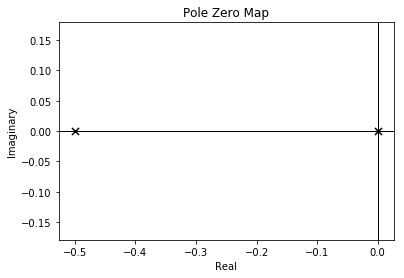

In [6]:
pzmap(sys)

Curvas de Bode

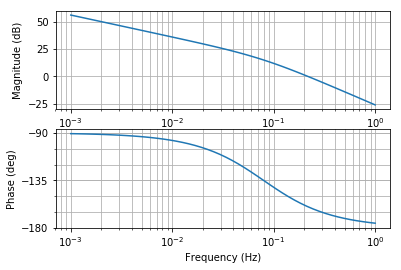

In [7]:
mag, phase, omega = bode(sys)

Extraindo os **parâmetros** frequenciais: margem de fase, margem de ganho, frequência de cruzamento de ganho e frequência de cruzamento de fase

In [8]:
gm, pm, wg, wp = margin(sys)

Margem de ganho **infinita**

In [9]:
gm

inf

Margem de fase

In [10]:
pm

20.040400498694623

Frequência para a margem de ganho

In [11]:
wg

nan

Frequência para a margem de fase

In [12]:
wp

1.3707306236949603

## 1. Projeto do Controlador - Método Frequencial


**Requisitos do sistema após a inserção do controlador:** <br> <br>
**gm** -> 6dB <br>
**pm** -> 60 graus <br>
**wp** -> 3

In [13]:
sys


     2
-----------
s^2 + 0.5 s

In [14]:
pm_new = 60

In [15]:
wp_new = 3

Fase [rad] do sistema para a w=3

In [16]:
sys_3j = evalfr(sys, 3j)
sys_3j

(-0.21621621621621623-0.036036036036036036j)

In [17]:
new_phase = np.angle(sys_3j)
new_phase

-2.976443976175166

In [18]:
G_sys_3j = 20*np.log10(np.abs(sys_3j))
G_sys_3j

-13.18324250850395

In [19]:
sys


     2
-----------
s^2 + 0.5 s

Fase em graus

In [20]:
new_phase = np.angle(sys_3j,deg=True)
new_phase

-170.53767779197437

Nova margem de fase:

In [21]:
mf = 180+new_phase
mf

9.462322208025626

Não satisfaz nosso requisito de uma margem de fase de 60graus. Vamos ver com quanto o controlador terá que contribuir:

In [22]:
deficit = pm_new - mf
deficit

50.537677791974374

$$\text{deficit} = tan^{-1}(\tau_d*w_{pnew})$$

In [23]:
tau_d = np.tan(np.deg2rad(deficit))/wp_new

In [24]:
tau_d

0.40490787757624686

In [25]:
print(1/tau_d)

2.469697566730332


In [26]:
G_sys_3j

-13.18324250850395

Para garantir fcg = wp_new temos que:

$$20 = \frac{G_{sys3j}-20*log(K_c)}{log(w_{pnew})-log(\frac{1}{\tau_d})}$$

In [27]:
from sympy import Symbol, solve, log
x = Symbol('x')

In [28]:
G_sys_3j

-13.18324250850395

In [110]:
kc = solve((20 - ((13.18324250850395-20*log(x,10))/(log(3, 10)-log(2.469697566730332, 10)))), rational=False)

In [111]:
kc

[3.75564595501899]

## 2. Simule a planta em malha aberta e fechada

### 2.1) Malha Aberta

Polos e zeros

In [112]:
sys


     2
-----------
s^2 + 0.5 s

(array([-0.5,  0. ]), array([], dtype=float64))

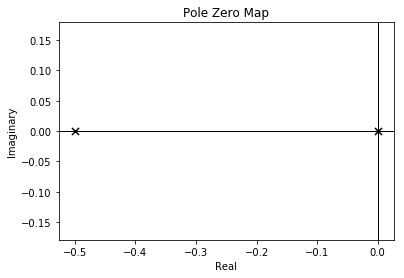

In [113]:
pzmap(sys)

Resposta ao degrau

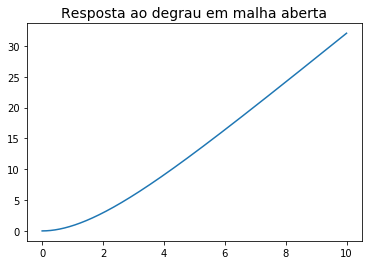

In [114]:
T = np.arange(0,10,0.001)
T, y = control.step_response(sys, T) 
plt.title("Resposta ao degrau em malha aberta", fontsize="14")
plt.plot(T, y)

### 2.2 Malha Fechada

In [115]:
sysmf_tf = sys / (1 + sys) 
sysmf_tf


        2 s^2 + s
------------------------
s^4 + s^3 + 2.25 s^2 + s

Polos e zeros

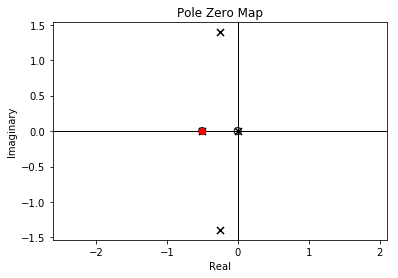

In [116]:
a = pzmap(sysmf_tf) 
plt.plot(a[1][0], a[1][1], 'or') 

Resposta ao degrau

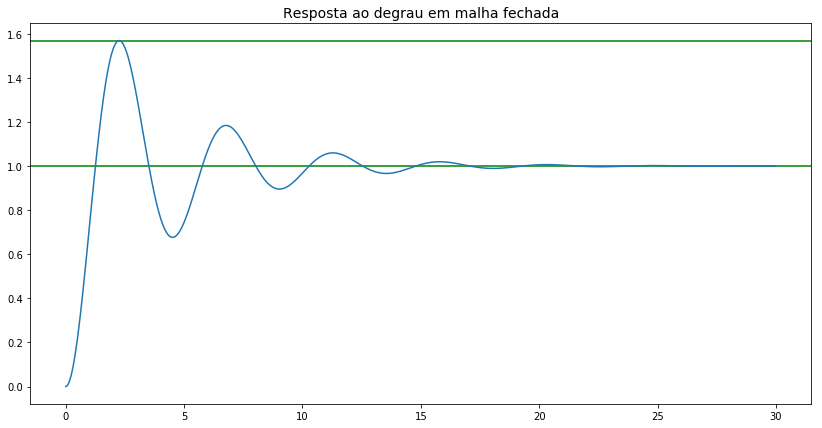

In [117]:
T = np.arange(0,30,.001)
T, y = control.step_response(sysmf_tf, T) 

plt.figure(figsize=(14, 7))

plt.axhline(y=y[-1], c='g') 
plt.axhline(y=y.max(), c='g') 

plt.title("Resposta ao degrau em malha fechada", fontsize="14")
plt.plot(T, y)

## Simulando com o Controlador PD

In [118]:
class PD(): 
  def __init__(self, kc: float, Td: float):
    self.kc, self.Td = kc, Td
    self.tf = tf([kc*Td, kc], [1]) # Define a transfer function

In [119]:
Ga = sys # FT de Malha Aberta
Ga


     2
-----------
s^2 + 0.5 s

A partir do que foi calculado pelo método frequencial, temos os coeficientes do controlador PD sendo:

In [120]:
tau_d

0.40490787757624686

In [121]:
kc[0]

3.75564595501899

In [122]:
type(np.float(kc[0]))

float

In [123]:
kc = np.float(kc[0])

In [137]:
pd = PD(kc=kc, Td=tau_d) # Controlador 
print("FT do controlador PD")
Gc = pd.tf # Controlador 
Gc

FT do controlador PD



1.521 s + 3.756
---------------
       1

### 2.3 Malha fechada com o controlador PD

In [139]:
GF = (Ga*Gc)/(1 + Ga*Gc) #Malha Fechada com controlador PD
GF


   3.041 s^3 + 9.032 s^2 + 3.756 s
-------------------------------------
s^4 + 4.041 s^3 + 9.282 s^2 + 3.756 s

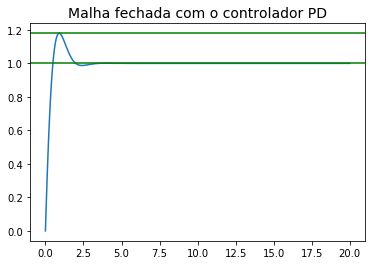

In [126]:
T = np.arange(0,20,.001)
T, y = control.step_response(GF, T) 
plt.plot(T, y)
plt.title("Malha fechada com o controlador PD", fontsize="14")
plt.axhline(y=y[-1], c='g') 
plt.axhline(y=y.max(), c='g') 

### 2.4 Malha aberta com o controlador PD

In [127]:
G = (Ga*Gc) #Malha aberta com controlador PD
G


3.041 s + 7.511
---------------
  s^2 + 0.5 s

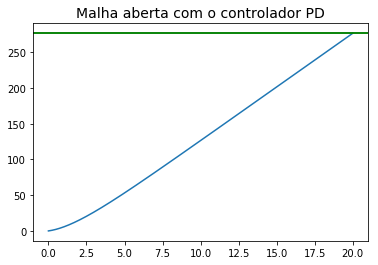

In [128]:
T = np.arange(0,20,.001)
T, y = control.step_response(G, T) 
plt.plot(T, y)
plt.title("Malha aberta com o controlador PD", fontsize="14")
plt.axhline(y=y[-1], c='g') 
plt.axhline(y=y.max(), c='g')

### Analisando os parâmetros frequenciais, considerando PD + sistema em malha fechada:

Relembrando, curvas de bode do **sistema**:

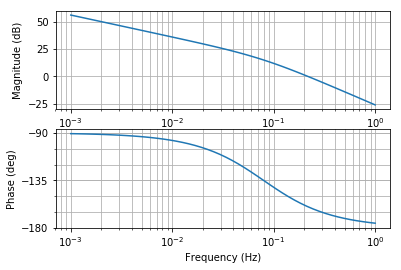

In [129]:
mag, phase, omega = bode(sys)

Agora, curvas de bode do **controlador PD**:

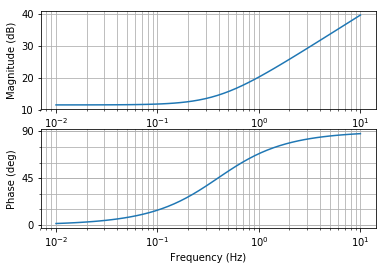

In [130]:
mag, phase, omega = bode(Gc)

Finalmente, curvas de bode do **controlador PD + sistema em malha fechada**:

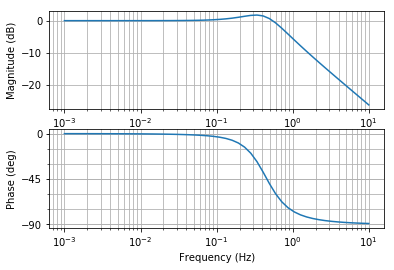

In [131]:
mag, phase, omega = bode(GF)

Parâmetros frequenciais:

In [140]:
gm, pm, wg, wp = margin(GF)

In [141]:
gm

inf

In [142]:
pm

125.02308010352834

In [143]:
wg

nan

In [144]:
wp

3.42508431355008